# Unsupervised Wine

The curse of dimensionality: When datasets have tons of features, it becomes nearly impossible for ML models to generalize effectively or uncover real structure. In this notebook, we'll use the popular `load_wine` [dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) from Scikit-Learn to explore how **Principal Component Analysis, or PCA**, can be utilized to beat this curse.

We'll see how PCA can:
- Cluster messy datasets without labels
- Supercharge pipelines for classification models like Support Vector Machines (SVM)
- Go head-to-head with a supervised decision tree -- a showdown that underscores the power of unsupervised learning techniques in the real world when labels are so often missing

**Acknowledgments**: This notebook is based on a lecture from Tao Li, Associate Professor in the Department of Information & Analytics at the Leavey School of Business at Santa Clara University. As always, thanks to the professor for inspiring this deep dive.

### Load and explore the dataset

In [1]:
# Start with the imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline

Let's begin by importing and loading the dataset.

In [2]:
# Import and load the dataset from sklearn
from sklearn.datasets import load_wine
wine = load_wine()

In [3]:
# Check the shape of the dataset
# This will tell us how many observations/patients (rows) we have and how many features (columns)
wine.data.shape

(178, 13)

Now, let's take a closer look at those 13 features.

In [4]:
# Check the feature names
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

### Plot first, model second

Before diving into the model building, let's do some data visualization to better understand the dataset we're working with.

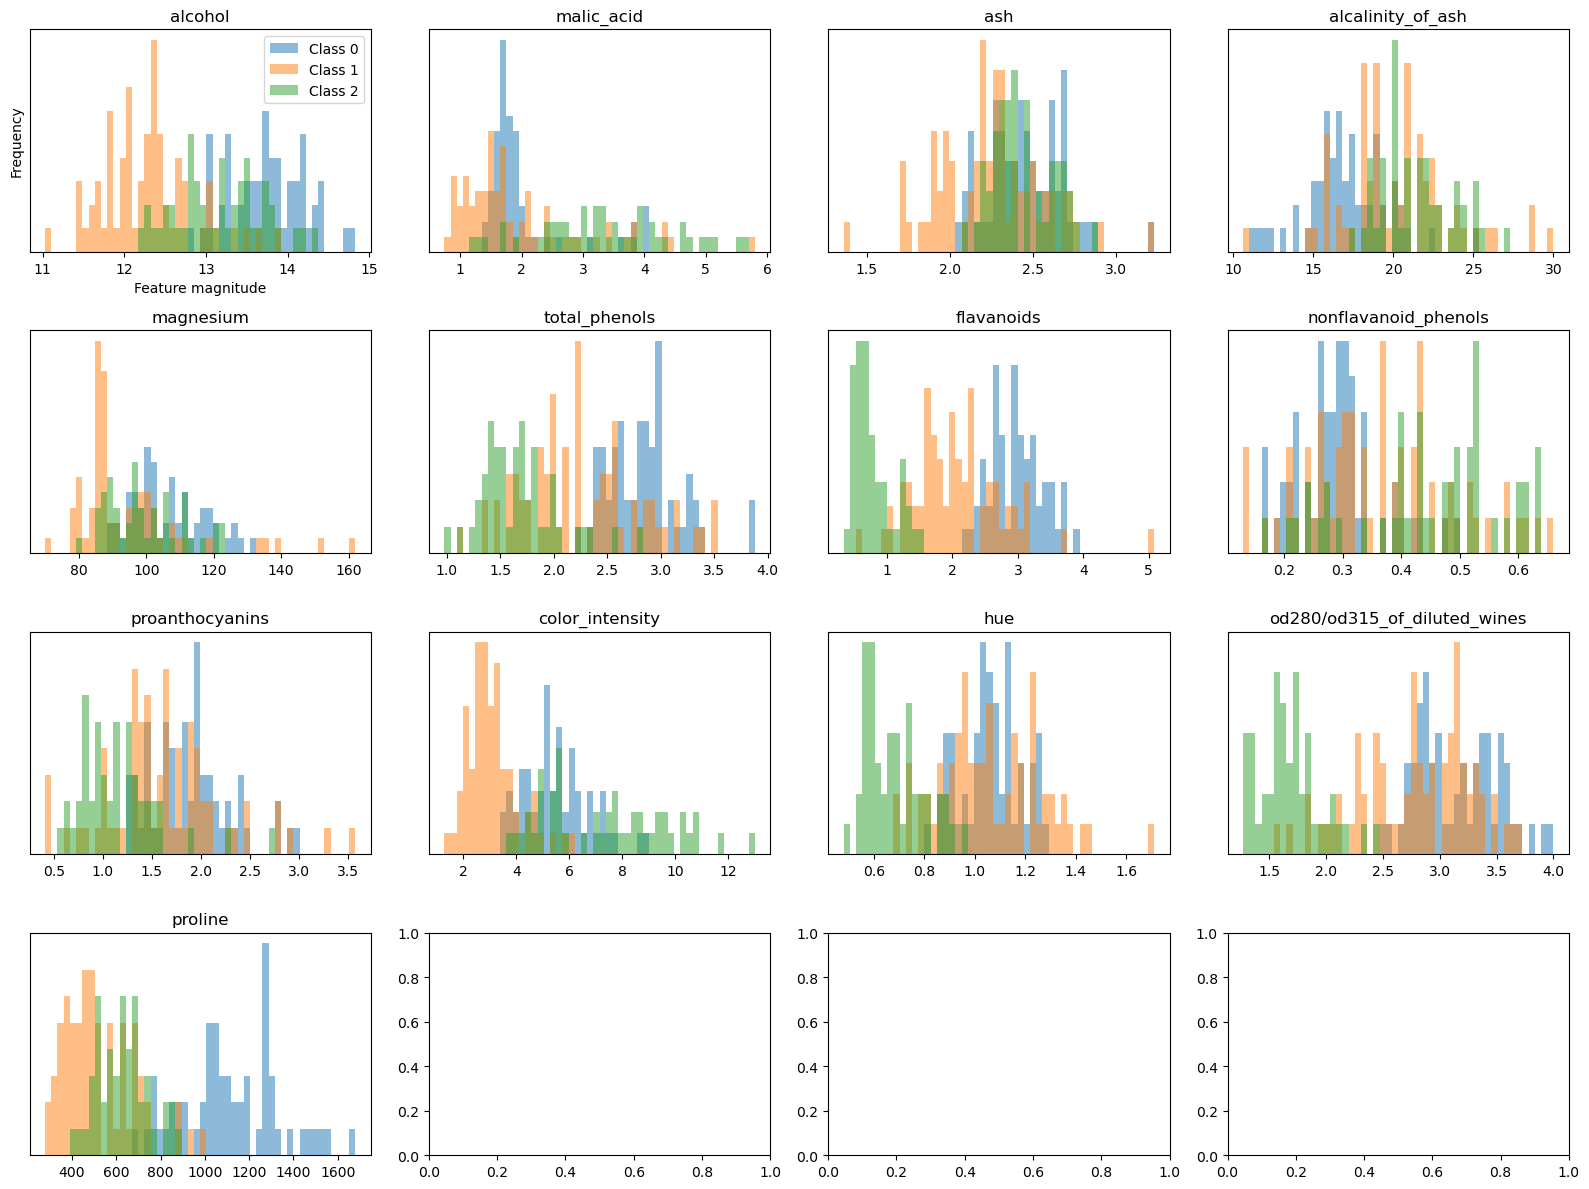

In [5]:
# Set up a figure: 13 features, let's do 4 rows x 4 cols for grid (one empty spot)
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
ax = axes.ravel()

# Assign feature names, data matrix, and class labels from the loaded wine dataset
feature_names = wine.feature_names
X = wine.data
y = wine.target

# For each feature, plot the histogram for each wine class (0, 1, 2)
for i in range(len(feature_names)):
    # Get the bins from the full data for fair comparison
    _, bins = np.histogram(X[:, i], bins=50)
    for label in np.unique(y):
        ax[i].hist(X[y == label, i], bins=bins, alpha=0.5, label=f"Class {label}")
    ax[i].set_title(feature_names[i])
    ax[i].set_yticks(())
    # Add legend only to first plot
    if i == 0:
        ax[i].legend()
    # Label x and y for first plot only
    if i == 0:
        ax[i].set_xlabel("Feature magnitude")
        ax[i].set_ylabel("Frequency")

# Adjust layout to prevent overlap between subplots -- this is important!
fig.tight_layout()

# Display the plots
plt.show()

Look at all that overlap! This is going to be a tricky clustering task as the three classes aren't clearly separated by any single feature. Scanning through the histograms, `flavanoids` stands out as a feature that could offer the clearest separation between classes, and by extension, could be a strong predictor of classes.

**Sidenote**: It really should be *flavonoids* but original the datset includes a typo!

Now back to the histograms. There is a more systematic and scaled approach than simply looking through these 13 histograms -- utilizing Principal Component Analysis. PCA allows us to capture the most important structure in the data by reducing its dimensionality. This can help reveal patterns or separations that aren’t obvious from any single feature.


**Before running PCA, it's crucial to scale the data** -- especially when the features are measured in different units or have very different ranges.

Why?

PCA works by finding directions (principal components) that maximize variance. If you don’t scale, features with large numeric values will dominate the calculation.

### Build a pipeline with PCA

As we discussed above, we'll begin by scaling.

In [6]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

Now, to **build the pipeline with two steps**: 1) `StandardScaler` and 2) `PCA`.

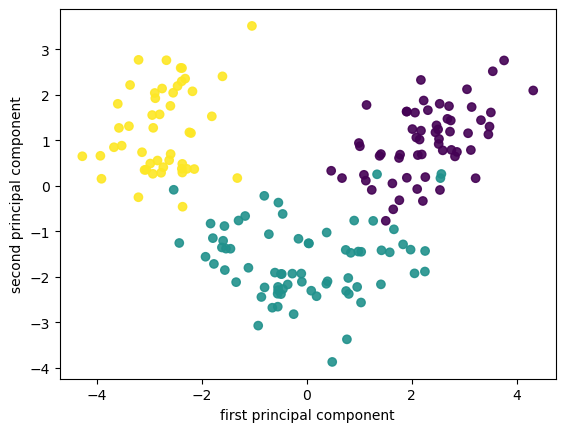

In [7]:
# Import Principal Component Analysis, or PCA
from sklearn.decomposition import PCA

# Build thhe pipeline using StandardScaler and PCA; For PCA, set the number of components -- one of the key parameters --
# which specifies how many principal components you'd like to return
pca_scaled = make_pipeline(StandardScaler(), PCA(n_components=2))

# Fit and transform the pipeline using the dataset
# Note: Because this is unsupervised learning, we aren't using the labels and aren't
# splitting the dataset into training and test sets
X_pca_scaled = pca_scaled.fit_transform(wine.data)

# Use the two principal components to draw the scatter plot
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=wine.target, alpha=.9)
plt.xlabel("first principal component")
plt.ylabel("second principal component")

# Display the plot
plt.show()

Oooo. Look at the power of PCA. With a single block of code we turned the mess of a dataset into three clearly distinguisable clusters.

This indicates that when running a classifier -- like a Support Vector Machine (SVM) -- it can be helpful to utilize PCA first and then use the principal components to do the classification. So, now let's build a model.

### Build and compare a selection of models

Next, let's see how we can build a SVM with PCA as one of the steps. First, let's build our baseline model.

In [20]:
# Import SVC, the model we will stack on top of PCA
from sklearn.svm import SVC

Split the data.

In [9]:
# Import train_test split
# Split the data into training and test sets; Be sure to specify the features and target,
# also stratify to maintain class balance in the training and test sets, and finally set
# random_state=0 for reproducibility
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, stratify=wine.target, random_state=0)

Now, build the first model.

In [10]:
# Initialize the SVC model and fit it on the training set
# Note: Use a linear kernel for SVM, which is good for linearly separable data after PCA,
# and 'ovr' for multi-class classification
svm = SVC(kernel='linear', decision_function_shape='ovr').fit(X_train, y_train)

# Evaluate the model on the training set
print(svm.score(X_train, y_train))

# Evaluate the model on the test set
print(svm.score(X_test, y_test))

1.0
0.9777777777777777


That "perfect" performance on the training set is an immediate red flag that the baseline model is overfitting (or simply memorizing) the dataset. Up next, let's see what happens when we scale the data.

In [11]:
# Import make_pipeline
from sklearn.pipeline import make_pipeline

# Build the pipeline with two steps: 1) StandardScaler() and 2) The LogisticRegression
# model 
scaled_svm = make_pipeline(StandardScaler(), SVC(kernel='linear', decision_function_shape='ovr'))

# Fit the new model on the training set
scaled_svm.fit(X_train, y_train)

# Evaluate the model on the training set
print(scaled_svm.score(X_train, y_train))

# Evaluate the model on the test set
print(scaled_svm.score(X_test, y_test))

1.0
0.9777777777777777


The results are the exact same! We clerly are still running into an overfittting issue.

Let's see what happens when we **add PCA to the pipeline** for dimensionality reduction.

In [12]:
# Build the pipeline with three steps: 1) StandardScaler(), 2) PCA, specifying 2 principal components
# and 3) The SVC model that we previously used above
pca_svm = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(kernel='linear', decision_function_shape='ovr'))

# Fit this model on the training set
pca_svm.fit(X_train, y_train)

# Evaluate the model on the training set
print(pca_svm.score(X_train, y_train))

# Evaluate the model on the test set
print(pca_svm.score(X_test, y_test))

0.9624060150375939
0.9555555555555556


These are exactly the sort of results we were hoping to see. By scaling and then running PCA, our model is delivering high accuracy on both the training *and* test sets -- without a perfect training score, a clear indicator of overfitting. Simply put: This model is generalizing better to unseen data.

It's worth noting that the original model used 13 features and this one uses just 2 principal components. So, what will happen if we increase the number of principal components to 6?

In [13]:
# Build the pipeline -- the only difference from above is that now the PCA step includes
# 6 components
pca_6 = make_pipeline(StandardScaler(), PCA(n_components=6), SVC(kernel='linear', decision_function_shape='ovr'))

# Fit this model on the training set
pca_6.fit(X_train, y_train)

# Evaluate on the training set
print(pca_6.score(X_train, y_train))

# Evaluate on the test set
print(pca_6.score(X_test, y_test))

0.9924812030075187
1.0


Increasing to 6 principal components boosts our accuracy even further -- possibly *too far*. When the model scores perfectly, especially on a small dataset, it’s often a sign that it’s fitting a bit too well. Sometimes, “good enough” is better than “perfect.”

Let's briefly explore another way to set the ideal number of components.

We'll **run a model where the number of components is set to 0.95**. 0.95? Whenever this parameter is set to a number between 0 and 1, Scikit-Learn will automatically intrepret this as the percentage of variance you'd like to capture. So, Scikit-Learn will set the number of components to make sure the variance threshold is met.

In [14]:
# Same model we have been building but with 0.95 components
pca_95 = make_pipeline(StandardScaler(), PCA(n_components=0.95), SVC(kernel='linear', decision_function_shape='ovr'))

# Fit the model on the training set
pca_95.fit(X_train, y_train)

# Evaluate on the training set
print(pca_95.score(X_train, y_train))

# Evaluate on the test set
print(pca_95.score(X_test, y_test))

0.9924812030075187
1.0


The results are the exact same as before. Looks like no matter how we pick the number of components, the PCA-boosted model nails this dataset. This underscores how simple (and small) the wine dataset is after a little PCA magic.

**So, the obvious question: Which of these models should we pick?**

In this task there wasn't much difference in terms of how we selected the number of principal components. If this were a real-world project, the best model would be the simplest model that generalizes well. So, `n_components=2` would be the way to go. **In short**: Simple models are easier to interpret and less likely to overfit on large, messy datasets.

### Visualize the importance of each principal component

Just for fun, here’s a quick look at how much information each principal component keeps. This plot explains why we can get away with just two components.

In [15]:
# Let's check the shape of the training set
# Just want to make sure it's still the right shape!
X_train.shape

(133, 13)

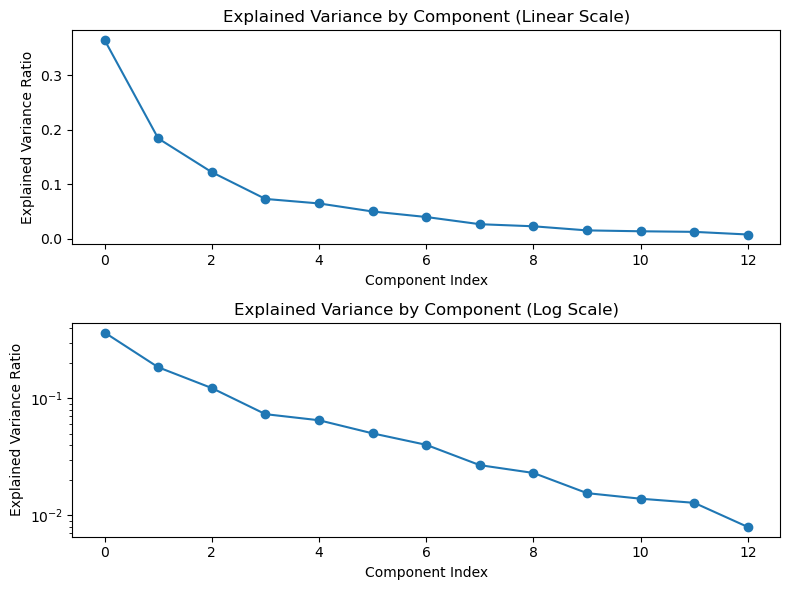

In [16]:
# Build a pipeline to scale the data and apply PCA (no classifier, just for explained variance)
explained_variance_pca = make_pipeline(StandardScaler(), PCA())
explained_variance_pca.fit(X_train, y_train)

# Extract the fitted PCA object
pca = explained_variance_pca.named_steps['pca']

# Plot explained variance for each principal component
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
axes[0].plot(pca.explained_variance_ratio_, marker='o')
axes[0].set_title('Explained Variance by Component (Linear Scale)')
axes[0].set_xlabel("Component Index")
axes[0].set_ylabel("Explained Variance Ratio")

axes[1].semilogy(pca.explained_variance_ratio_, marker='o')
axes[1].set_title('Explained Variance by Component (Log Scale)')
axes[1].set_xlabel("Component Index")
axes[1].set_ylabel("Explained Variance Ratio")

# Adjust the layout to prevent overlap between subpots
plt.tight_layout()

# Display the plots
plt.show()

These plots demonstrate that **the first two principal components capture most of the important variation in the dataset**, which tracks perfectly with what our models showed us. After those first two components, the additional components only add a tiny bit more of information.

That's exactly why our PCA-boosted SVM model worked so well with two components or six.

### Run an unsupersived vs. supervised showdown

Let's see how the PCA-powered SVM pipeline stacks up against a decision tree on this dataset. **A classic unsupervised vs. supervised showndown**. The decision tree that we'll be running the comparison with comes from a previous notebook, which was named: [Chaos Isnt' a Ladder -- It's a Tree](https://github.com/karlbuscheck/chaos-is-a-tree). 

We'll grab that code for the best tree from that notebook -- with a max depth of three -- and drop into into this notebook below.

In [17]:
# Import DecisionTreeClassifier and export_graphviz from sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Import plot_tree from sklearn, which visualizes the decision tree structure
from sklearn.tree import plot_tree

# Build the tree with max_depth=3, so three levels and criterion set to 'entropy'
# to split based on information gain, or reduction in impurity
tree_3 = DecisionTreeClassifier(max_depth=3, criterion='entropy')

# Fit the tree to the training set
tree_3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

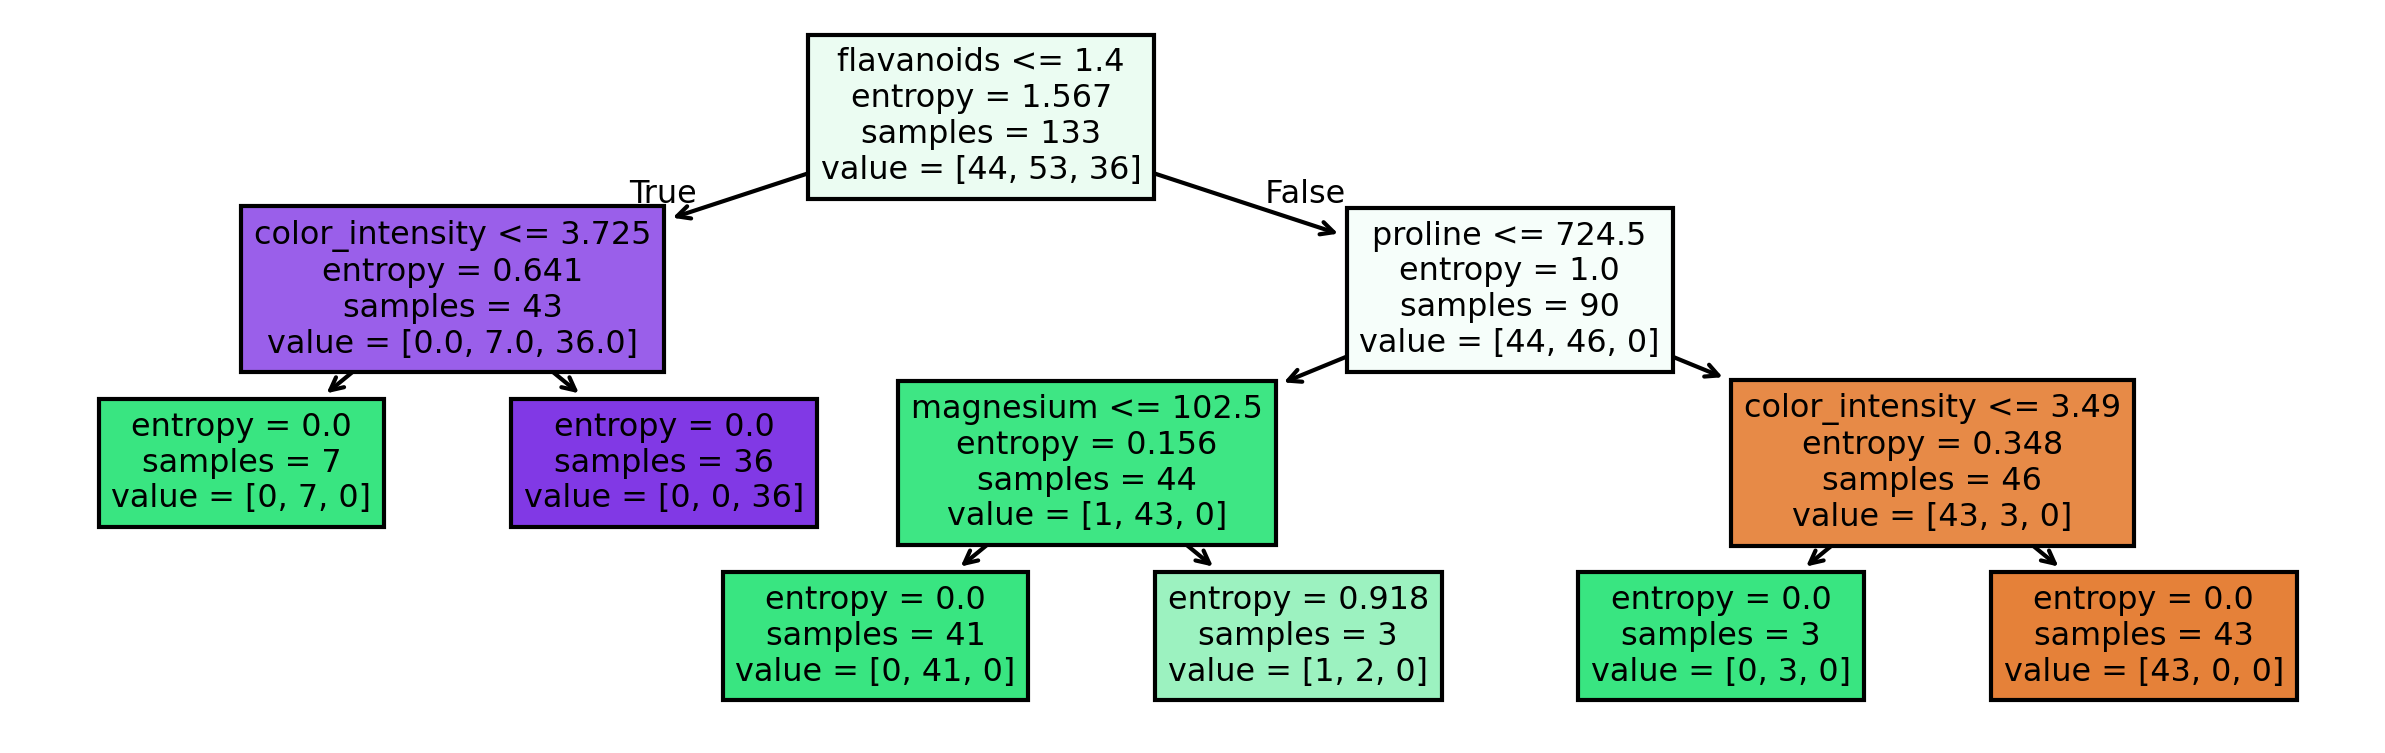

In [18]:
# Set the plot size and resolution for better readability
plt.figure(figsize=(10, 3), dpi=300)

# Plot 'tree_3' with feature names and colored nodes
tree_3_dot = plot_tree(tree_3, feature_names=wine.feature_names, filled=True)

# Display the plot
plt.show()

This simple tree looks quite powerful. We can confirm that by checking the performance on the test set.

In [19]:
# Check the accuracy on the test set
print("Depth 3 Accuracy:", tree_3.score(X_test, y_test))

Depth 3 Accuracy: 0.9777777777777777


**Takeaway**: The decision tree performed better on the test set -- about 97.8% to 95.6% -- but it's pretty remarkable to see how well the PCA-boosted SVM model actually did. After all, the decision tree has the benefit of learning from the *actual* labels, while the unsupervised model found its own class boundaries just from picking up on the main structure of the dataset.

Unsurprisingly, the supervised model outperformed the unsupervised one. It goes without saying: When you have labels, use them. But in the real world, when so much data is unlabeled, unsupervised models -- like PCA + SVM -- can be a remarkably powerful tool.